In [1]:
# Import modules
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import os

In [2]:
# Load data

# County boundaries
# Source: https://opendata.mtc.ca.gov/datasets/san-francisco-bay-region-counties-clipped?geometry=-125.590%2C37.123%2C-119.152%2C38.640
path2 = os.getcwd()+ '\Dados vetoriais\Piracicaba\Perimetro_Piracicaba.shp'
counties = gpd.read_file(path2)

# Rainfall measurement "locations"
# Source: https://earthworks.stanford.edu/catalog/stanford-td754wr4701
# Modified by author by clipping raster to San Francisco Bay Area, generating random points, and extracting raster values (0-255) to the points
path = os.getcwd()+ '\Dados vetoriais\Pontos amostrais_Piracicaba\Dados_227pts_original_06_03_2021.shp'
rainfall = gpd.read_file(path)

# Reproject data to CA Teale Albert
# https://nrm.dfg.ca.gov/FileHandler.ashx?DocumentID=109326&inline
proj = counties.crs
counties = counties.to_crs(proj)
rainfall = rainfall.to_crs(proj)

In [3]:
# Get X and Y coordinates of rainfall points
x_rain = rainfall["geometry"].x
y_rain = rainfall["geometry"].y

# Create list of XY coordinate pairs
coords_rain = [list(xy) for xy in zip(x_rain, y_rain)]

# Get extent of counties feature
min_x_counties, min_y_counties, max_x_counties, max_y_counties = counties.total_bounds

# Get list of rainfall "values"
value_rain = list(rainfall["Argila"])

# Create a copy of counties dataset
counties_dissolved = counties.copy()

# Add a field with constant value of 1
counties_dissolved["constant"] = 1

# Dissolve all counties to create one polygon
counties_dissolved = counties_dissolved.dissolve(by = "constant").reset_index(drop = True)

In [4]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z.shape[0],
            width = Z.shape[1],
            count = 1,
            dtype = Z.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z, 1)

In [5]:
# Split data into testing and training sets
coords_rain_train, coords_rain_test, value_rain_train, value_rain_test = train_test_split(coords_rain, value_rain, test_size = 0.20, random_state = 42)

# Create separate GeoDataFrames for testing and training sets
rain_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_train], crs = proj)
rain_train_gdf["Actual_Value"] = value_rain_train
rain_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_test], crs = proj)
rain_test_gdf["Actual_Value"] = value_rain_test

# Get minimum and maximum coordinate values of rainfall training points
min_x_rain, min_y_rain, max_x_rain, max_y_rain = rain_train_gdf.total_bounds

Text(0.5, 1.0, 'San Francisco Bay Area - Rainfall Measurement Locations')

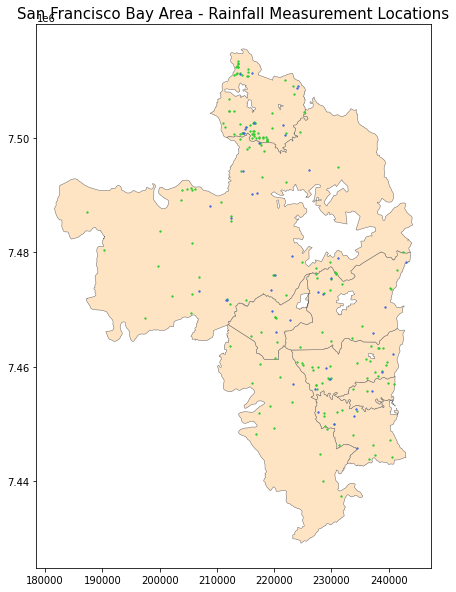

In [6]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Stylize plots
plt.style.use('bmh')

# Plot data
counties.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
rain_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 3)
rain_test_gdf.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 3)
# Set title
ax.set_title('San Francisco Bay Area - Rainfall Measurement Locations', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [7]:
# Set projection to WGS 84 and reproject data
proj_wgs = proj
counties_wgs = counties.to_crs(proj_wgs)
rainfall_wgs = rainfall.to_crs(proj_wgs)
rain_train_gdf_wgs = rain_train_gdf.to_crs(proj_wgs)
rain_test_gdf_wgs = rain_test_gdf.to_crs(proj_wgs)

# Get X and Y coordinates of rainfall points
x_rain_wgs = rainfall_wgs["geometry"].x
y_rain_wgs = rainfall_wgs["geometry"].y

# Create list of XY coordinate pairs
coords_rain_train_wgs = [list(xy) for xy in zip(rain_train_gdf_wgs["geometry"].x, rain_train_gdf_wgs["geometry"].y)]
coords_rain_test_wgs = [list(xy) for xy in zip(rain_test_gdf_wgs["geometry"].x, rain_test_gdf_wgs["geometry"].y)]

# Get minimum and maximum coordinate values of rainfall points
min_x_rain_wgs, min_y_rain_wgs, max_x_rain_wgs, max_y_rain_wgs = rain_train_gdf_wgs.total_bounds

PyKrige Kriging out-of-sample r-squared: 0.32

Attribute Table: Random Points Interpolated Values - PyKrige Kriging Method


,geometry,Actual_Value,VALUE_Predict
0,POINT (214547.757 7494154.735),8.3,18.050085
1,POINT (211741.829 7471655.416),20.0,17.810329


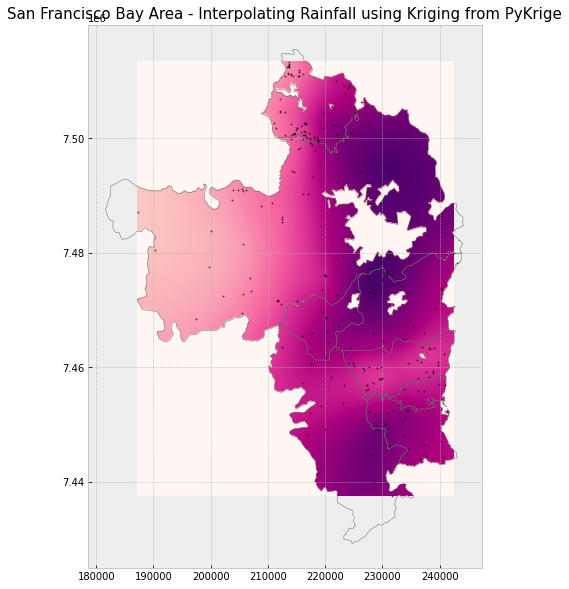

In [8]:
# Adapted from: https://geostat-framework.readthedocs.io/projects/pykrige/en/latest/examples/04_krige_geometric.html

# Create a 100 by 100 grid
# Horizontal and vertical cell counts should be the same
XX_pk_krig = np.linspace(min_x_rain, max_x_rain, 1000)
YY_pk_krig = np.linspace(min_y_rain, max_y_rain, 1000)

# Generate ordinary kriging object
OK = OrdinaryKriging(
    np.array(x_rain),
    np.array(y_rain),
    value_rain,
    variogram_model = "linear",
    verbose = False,
    enable_plotting = False,
    coordinates_type = "euclidean",
)

# Evaluate the method on grid
Z_pk_krig, sigma_squared_p_krig = OK.execute("grid", XX_pk_krig, YY_pk_krig)

# Export raster
export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                  min_x = min_x_rain, max_x = max_x_rain, min_y = min_y_rain, max_y = max_y_rain,
                  proj = proj, filename = os.getcwd() + "\e_bay-area-rain_pk_kriging.tif")

# Open raster
raster_pk = rasterio.open(os.getcwd() + "\e_bay-area-rain_pk_kriging.tif")


# Create polygon with extent of raster
poly_shapely = box(*raster_pk.bounds)

# Create a dictionary with needed attributes and required geometry column
attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

# Convert shapely object to a GeoDataFrame
raster_pk_extent = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = proj)

# Create copy of test dataset
rain_test_gdf_pk_krig = rain_test_gdf.copy()

# Subset the GeoDataFrame by checking which test points are within the raster extent polygon
# If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
rain_test_gdf_pk_krig = rain_test_gdf_pk_krig[rain_test_gdf_pk_krig.within(raster_pk_extent.geometry.values[0])]

# Create list of XY coordinate pairs for the test points that fall within raster extent polygon
coords_rain_test_pk_krig = [list(xy) for xy in zip(rain_test_gdf_pk_krig["geometry"].x, rain_test_gdf_pk_krig["geometry"].y)]

# Extract raster value at each test point and add the values to the GeoDataFrame
rain_test_gdf_pk_krig["VALUE_Predict"] = [x[0] for x in raster_pk.sample(coords_rain_test_pk_krig)]

# Generate out-of-sample R^2
out_r_squared_tp = r2_score(rain_test_gdf_pk_krig.Actual_Value, rain_test_gdf_pk_krig.VALUE_Predict)
print("PyKrige Kriging out-of-sample r-squared: {}".format(round(out_r_squared_tp, 2)))

# Display attribute table
print("\nAttribute Table: Random Points Interpolated Values - PyKrige Kriging Method")
display(rain_test_gdf_pk_krig.head(2))


# Mask raster to counties shape
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, counties.geometry.values, crop = True)

# Stylize plots
plt.style.use('bmh')

# Plot data
fig, ax = plt.subplots(1, figsize = (10, 10))
show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = "RdPu")
ax.plot(x_rain, y_rain, 'k.', markersize = 2, alpha = 0.5)
counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
plt.gca().invert_yaxis()

# Set title
ax.set_title('San Francisco Bay Area - Interpolating Rainfall using Kriging from PyKrige', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()

In [9]:
# Adapted from: https://geostat-framework.readthedocs.io/projects/pykrige/en/latest/examples/04_krige_geometric.html

# Create a 100 by 100 grid
# Horizontal and vertical cell counts should be the same
XX_pk_krig = np.linspace(min_x_rain, max_x_rain, 100)
YY_pk_krig = np.linspace(min_y_rain, max_y_rain, 100)

# Generate ordinary kriging object
OK = OrdinaryKriging(
    np.array(x_rain),
    np.array(y_rain),
    value_rain,
    variogram_model = "linear",
    verbose = False,
    enable_plotting = False,
    coordinates_type = "euclidean",
)

PyKrige Kriging out-of-sample r-squared: 0.32

Attribute Table: Random Points Interpolated Values - PyKrige Kriging Method


,geometry,Actual_Value,VALUE_Predict
0,POINT (214547.757 7494154.735),8.3,18.050234
1,POINT (211741.829 7471655.416),20.0,17.778394


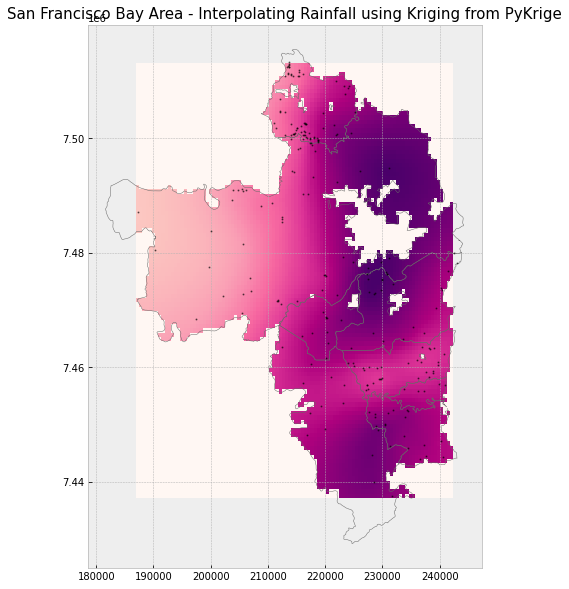

In [13]:
# Evaluate the method on grid
Z_pk_krig, sigma_squared_p_krig = OK.execute("grid", XX_pk_krig, YY_pk_krig)

# Export raster
export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                  min_x = min_x_rain, max_x = max_x_rain, min_y = min_y_rain, max_y = max_y_rain,
                  proj = proj, filename = os.getcwd() + "\e_bay-area-rain_pk_kriging.tif")

# Open raster
raster_pk = rasterio.open(os.getcwd() + "\e_bay-area-rain_pk_kriging.tif")


# Create polygon with extent of raster
poly_shapely = box(*raster_pk.bounds)

# Create a dictionary with needed attributes and required geometry column
attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

# Convert shapely object to a GeoDataFrame
raster_pk_extent = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = proj)

# Create copy of test dataset
rain_test_gdf_pk_krig = rain_test_gdf.copy()

# Subset the GeoDataFrame by checking which test points are within the raster extent polygon
# If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
rain_test_gdf_pk_krig = rain_test_gdf_pk_krig[rain_test_gdf_pk_krig.within(raster_pk_extent.geometry.values[0])]

# Create list of XY coordinate pairs for the test points that fall within raster extent polygon
coords_rain_test_pk_krig = [list(xy) for xy in zip(rain_test_gdf_pk_krig["geometry"].x, rain_test_gdf_pk_krig["geometry"].y)]

# Extract raster value at each test point and add the values to the GeoDataFrame
rain_test_gdf_pk_krig["VALUE_Predict"] = [x[0] for x in raster_pk.sample(coords_rain_test_pk_krig)]

# Generate out-of-sample R^2
out_r_squared_tp = r2_score(rain_test_gdf_pk_krig.Actual_Value, rain_test_gdf_pk_krig.VALUE_Predict)
print("PyKrige Kriging out-of-sample r-squared: {}".format(round(out_r_squared_tp, 2)))

# Display attribute table
print("\nAttribute Table: Random Points Interpolated Values - PyKrige Kriging Method")
display(rain_test_gdf_pk_krig.head(2))


# Mask raster to counties shape
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, counties.geometry.values, crop = True)

# Stylize plots
plt.style.use('bmh')

# Plot data
fig, ax = plt.subplots(1, figsize = (10, 10))
show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = "RdPu")
ax.plot(x_rain, y_rain, 'k.', markersize = 2, alpha = 0.5)
counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
plt.gca().invert_yaxis()

# Set title
ax.set_title('San Francisco Bay Area - Interpolating Rainfall using Kriging from PyKrige', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()

In [12]:
raster_pk.close()